# Process 10x data

## Purpose

This notebook processes 10x scRNA-seq data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublet and low quality cells. It also processes target site reads, filtering out alleles with insufficient coverage, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycea
import scanpy as sc
import anndata as ad
import treedata as td
import networkx as nx
import pycea
import numpy as np
from itertools import combinations
import multiprocessing as mp
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
from pathlib import Path
import petracer
np.random.seed(42)

from petracer.config import colors, sequential_cmap, site_names, full_edit_cmap
from petracer.seq import  sigma_threshold, select_allele
from petracer.tree import reconstruct_tree, alleles_to_characters
from petracer.clones import call_clones
site_names = list(site_names.keys())

base_path, data_path, plot_path, results_path = petracer.config.get_paths("invitro_heterogeneity")
petracer.config.set_theme()

%load_ext autoreload
%autoreload 2

## Load data

Specify samples and names

In [8]:
samples = {"4T1_invitro_rep1":"rep1","4T1_invitro_rep2":"rep2"}

Transciptome

In [3]:
adata = []
for sample, name in samples.items():
    adata_sample = sc.read_10x_h5(data_path / sample / f"{sample}_filtered_counts.h5")   
    adata_sample.var_names_make_unique()  
    adata.append(adata_sample)
adata = ad.concat(adata, join='outer',label = "sample", keys = list(samples.values()))  
adata.obs["cellBC"] = (adata.obs["sample"].astype(str) + "-" + adata.obs.index)  
adata.obs.index = adata.obs["cellBC"].values          

/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/lab/solexa_weissman/wcolgan/tools/miniconda3/envs/petracer/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplic

Target site

In [4]:
alleles = []
for sample, name in samples.items():
    sample_alleles = pd.read_csv(data_path / sample / f"{sample}_allele_counts.csv",keep_default_na=False)
    sample_alleles["sample"] = name
    sample_alleles["cellBC"] = (name + "-" + sample_alleles["cellBC"])
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(adata.obs.index)]

## Sequencing statistics

In [5]:
adata.var['TS'] = adata.var.index.str.startswith('intID')
adata.var['GEX'] = ~adata.var['TS']
adata.var['MT'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT',"TS","GEX"], percent_top=None, log1p=False, inplace=True)

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

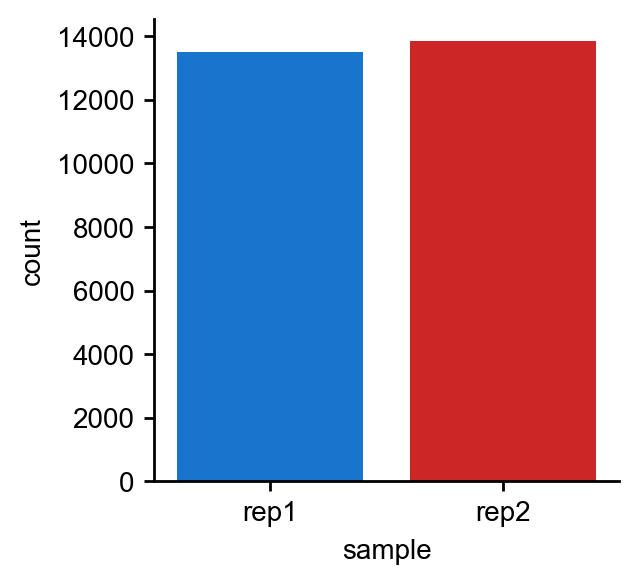

In [6]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

UMIs per cell per sample

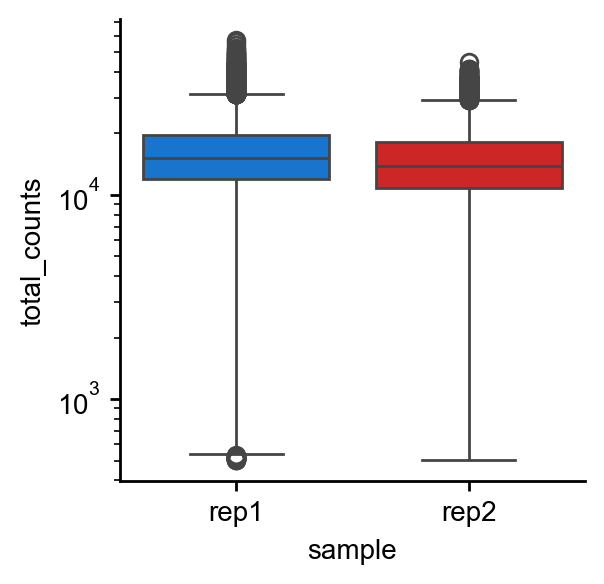

In [7]:
sns.boxplot(data = adata.obs, x = "sample", y = "total_counts",hue = "sample",legend=False,saturation = 1)
plt.yscale("log")

GEX UMIs vs TS UMIs per sample

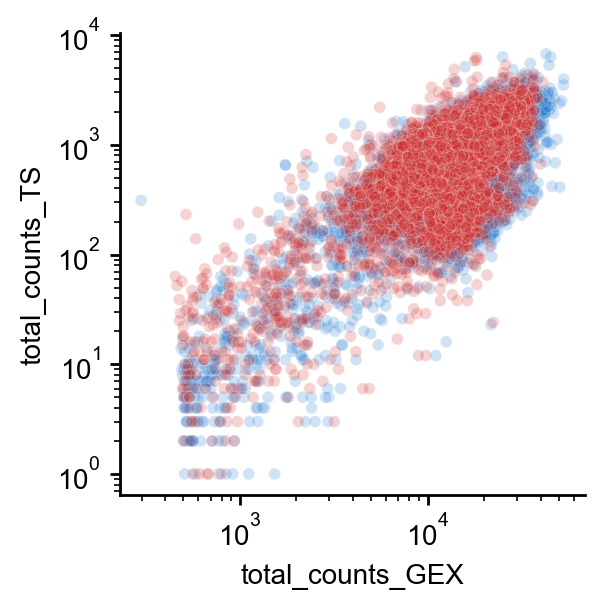

In [8]:
sns.scatterplot(data = adata.obs, x = "total_counts_GEX", y = "total_counts_TS",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.yscale("log")

## Low quality cells

In [9]:
adata.obs["type"] = "normal"
adata.obs["pct_counts_MT"] = adata.obs["total_counts_MT"]/adata.obs["total_counts_GEX"]*100

Cells with high mitochondrial content

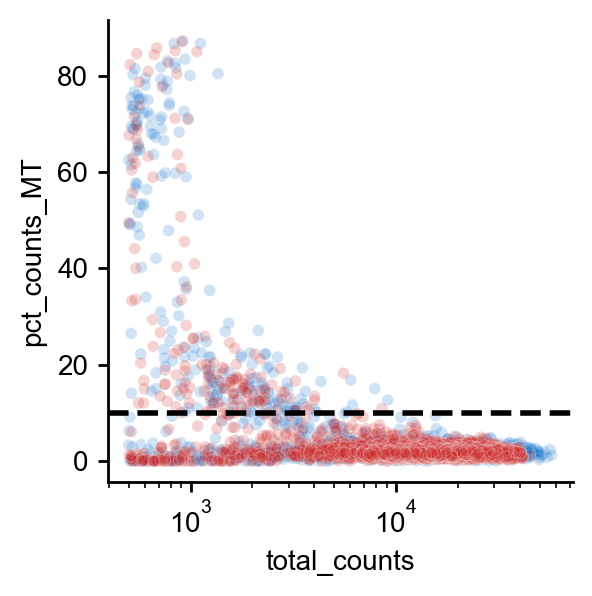

In [10]:
max_mt_pct = 10
adata.obs.loc[adata.obs["pct_counts_MT"] > max_mt_pct, "type"] = "high_mito"
sns.scatterplot(data = adata.obs, x = "total_counts", y = "pct_counts_MT",hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")
plt.axhline(y=max_mt_pct, color="black", linestyle="--")

Cells with too few UMIs

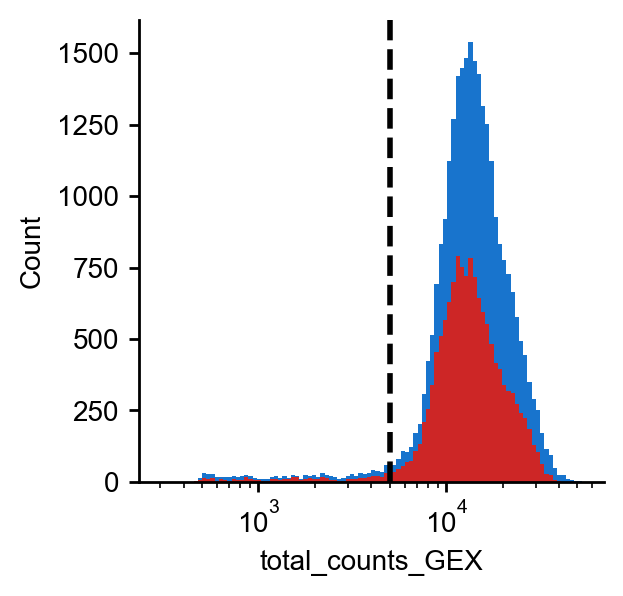

In [11]:
min_gex = 5000
adata.obs.loc[adata.obs["total_counts_GEX"] < min_gex, "type"] = "low_umi"
sns.histplot(data = adata.obs, x = "total_counts_GEX", hue = "sample", bins = 100, log_scale = True,
              legend=False, multiple="stack",linewidth=0,alpha = 1)
plt.axvline(x=min_gex, color="black", linestyle="--")

Cell types

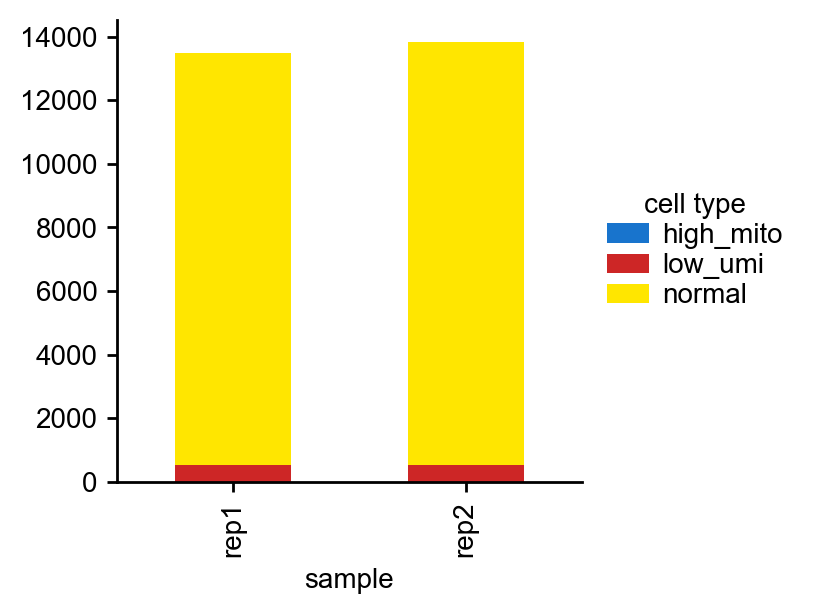

In [12]:
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Filter target site reads

In [13]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = alleles.query("cellBC.isin(@normal_cells) & UMI > 1").copy()
filtered_alleles["keep"] = True

Set minimum number of reads per UMI

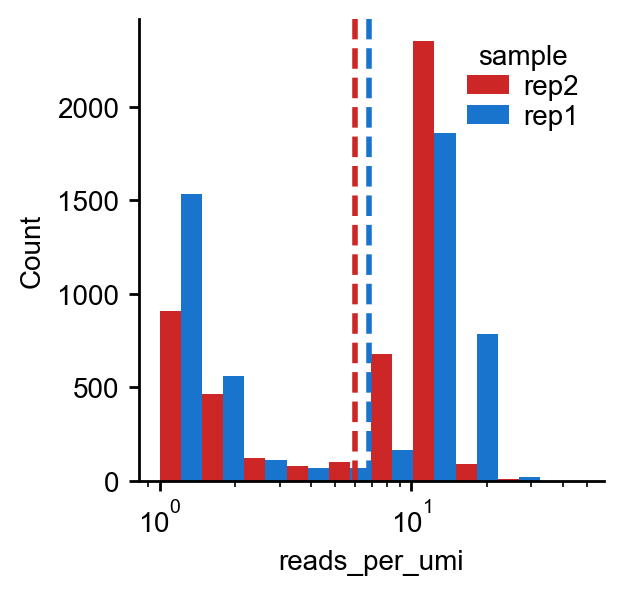

In [14]:
sample_colors = {sample:color for sample, color in zip(sorted(samples.values()),colors[1:])}
filtered_alleles["reads_per_umi"] = filtered_alleles["readCount"]/filtered_alleles["UMI"]
sns.histplot(data = filtered_alleles.sample(10000), x = "reads_per_umi", bins = 10,alpha = 1,
             log_scale = True, hue = "sample", multiple="dodge",linewidth=0,palette=sample_colors)
for sample, sample_alleles in filtered_alleles.groupby("sample"):
    cutoff = sigma_threshold(sample_alleles["reads_per_umi"],log = True)
    filtered_alleles.loc[(filtered_alleles["sample"] == sample) & (filtered_alleles["reads_per_umi"] < cutoff),"keep"] = False
    plt.axvline(x=cutoff, linestyle="--",color = sample_colors[sample])

Set minimum number of UMIs per target site for each sample

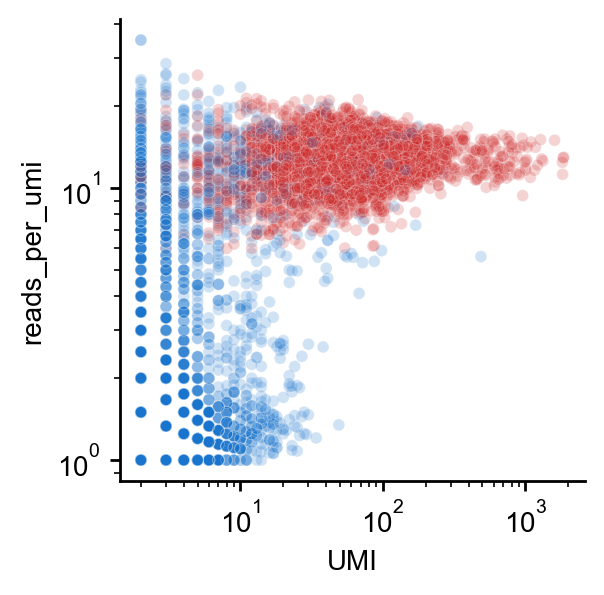

In [15]:
for sample, sample_alleles in filtered_alleles.query("keep").copy().groupby("sample"):
    for integration, int_alleles in sample_alleles.groupby("intID"):
        if len(int_alleles) < 100:
            threshold = np.inf
        else:
            threshold = sigma_threshold(int_alleles["UMI"],log = True)
        filtered_alleles.loc[(filtered_alleles["sample"] == sample) & 
                             (filtered_alleles["intID"] == integration) & 
                             (filtered_alleles["UMI"] <= threshold), "keep"] = False
sns.scatterplot(data = filtered_alleles.sample(10000), x = "UMI", y = "reads_per_umi",
                hue = "keep",size = .1,alpha = .2,legend=False)
plt.yscale("log")
plt.xscale("log")

In [16]:
filtered_alleles = filtered_alleles.query("keep").drop(columns="keep").copy()

## Identify clones

In [17]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

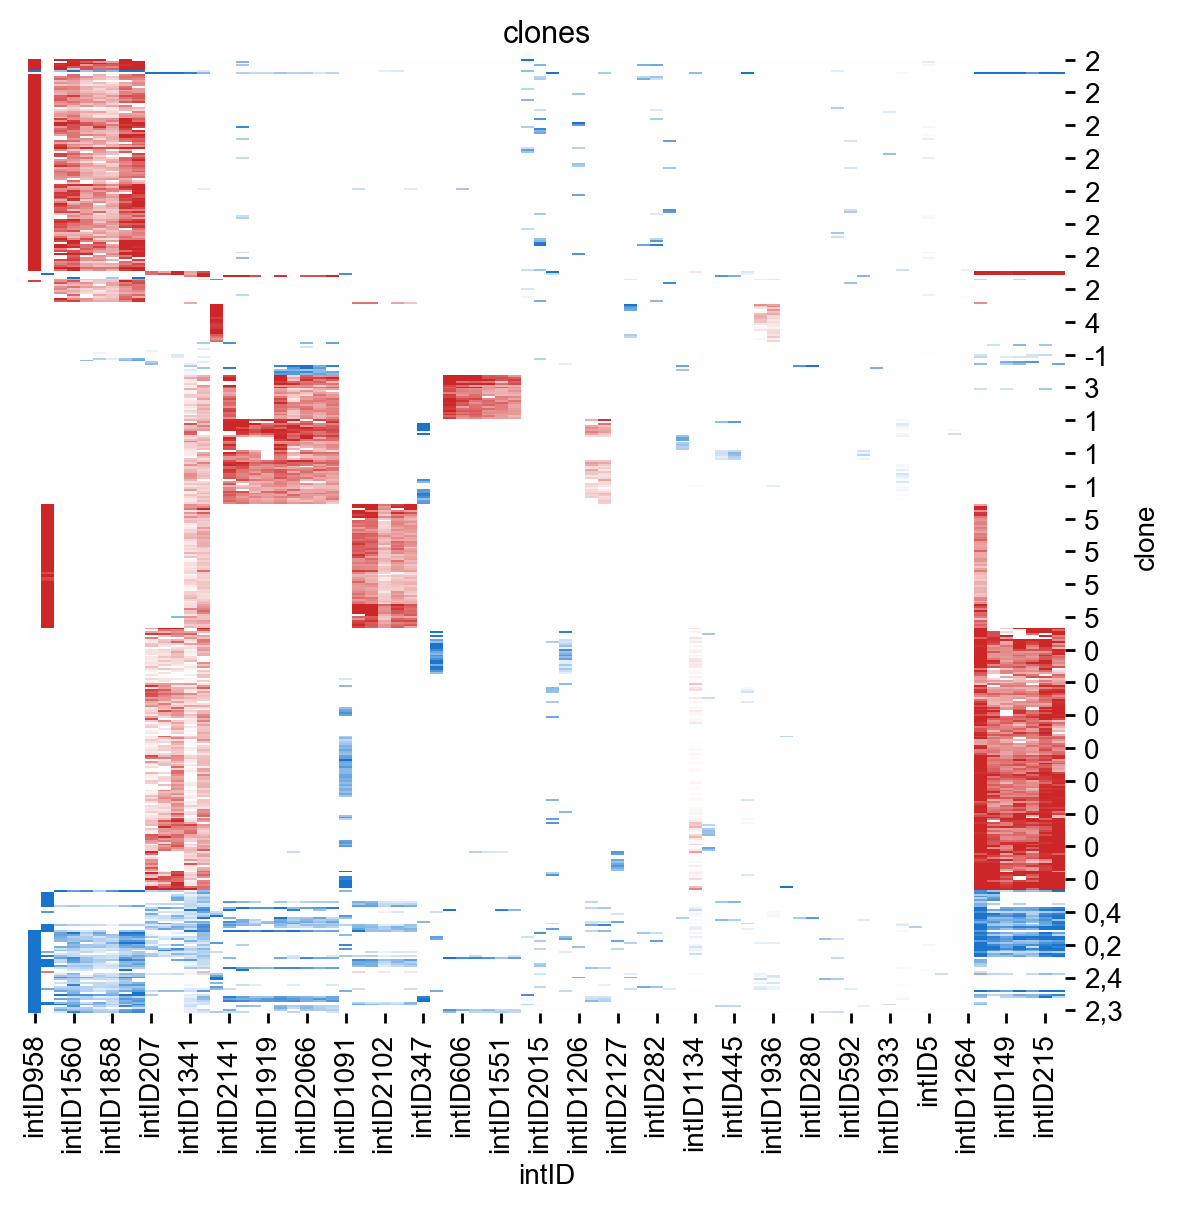

In [18]:
n_clones =  6
min_frac = .5
min_jaccard = .5
whitelist_alleles = []
cell_to_clone = []
model = SpectralClustering(n_clusters=n_clones)
whitelist_alleles, cell_to_clone = call_clones(filtered_alleles,
    model,plot_title = "clones",min_frac=min_frac,min_jaccard=min_jaccard)

Rename clones by size

In [19]:
clone_counts = cell_to_clone.query("whitelist").groupby(["clone"]).size().reset_index(name = "n").sort_values("n",ascending = False)
clone_counts["unique_clone"] = (clone_counts.reset_index().index + 1).astype(str)
clone_counts

,clone,n,unique_clone
0,0,7715,1
2,2,6353,2
5,5,3230,3
1,1,2178,4
4,4,1239,5
3,3,929,6


Add clone to cells and alleles

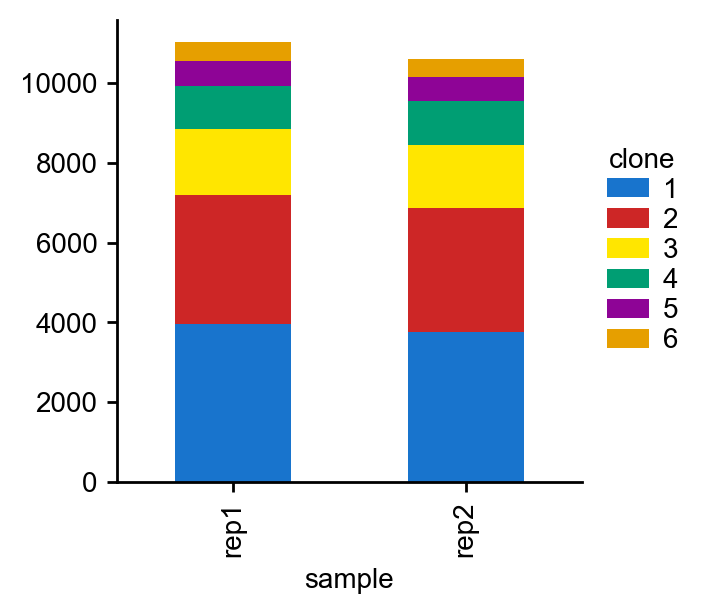

In [20]:
cell_to_clone = cell_to_clone.merge(clone_counts[["clone","unique_clone"]], on = ["clone"], how = "left")
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["unique_clone"])
adata.obs.groupby(['sample', 'clone'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Mark doublets and unassigned cells

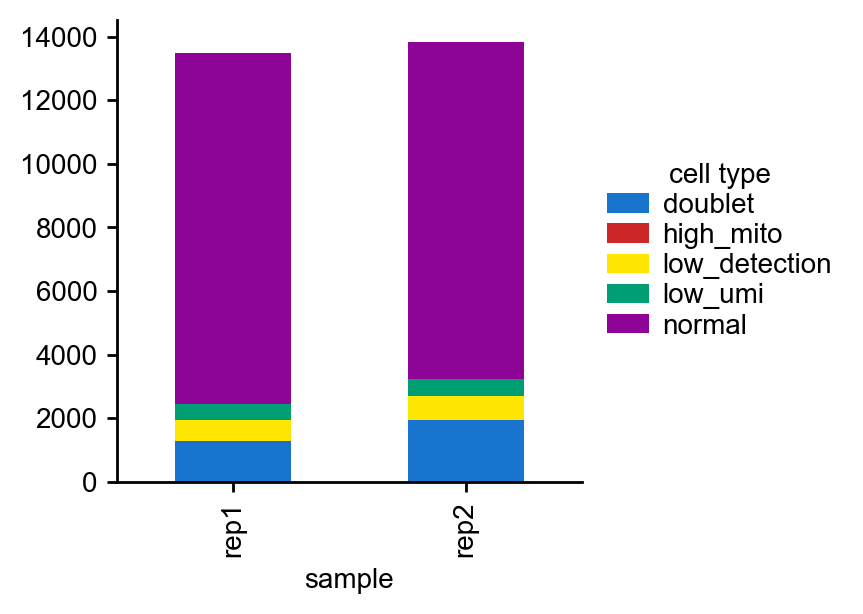

In [21]:
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.loc[(adata.obs.type == "normal") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

In [24]:
adata = adata[(adata.obs["type"] == "normal") & (adata.obs["clone"].notnull()),adata.var["GEX"]].copy()

## Clustering

In [26]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["normalized"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset = False)
sc.pp.scale(adata)
sc.tl.pca(adata, n_comps=20)
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=1)
sc.tl.leiden(adata, resolution=0.1, key_added="leiden_cluster",flavor="igraph")

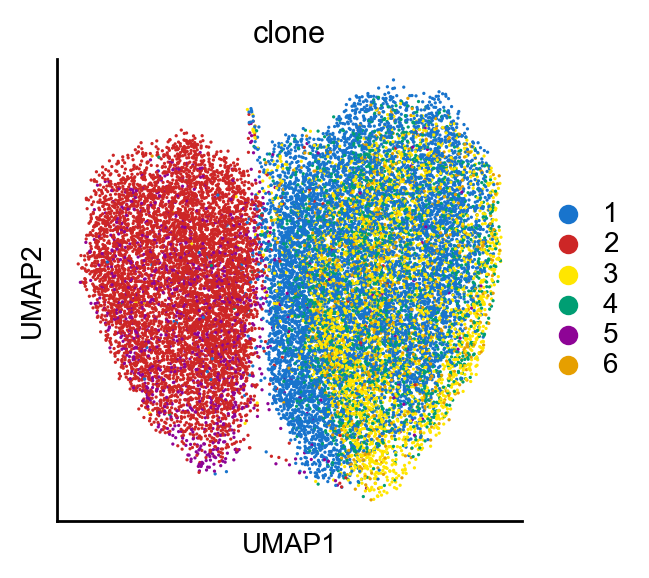

In [27]:
sc.pl.umap(adata, color=["clone"])

## Cell cycle

In [ ]:
g2m_genes = pd.read_csv(base_path / "reference" / "g2m_genes.csv", header=None).squeeze().tolist()
s_genes = pd.read_csv(base_path / "reference" / "s_genes.csv", header=None).squeeze().tolist()
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata.obs["phase"] = adata.obs["phase"].map({"G1":"G0/G1","S":"S","G2M":"G2/M"})

## Integration barcode mapping

Setup

In [6]:
from petracer.seq import correct_to_whitelist

Load data

In [60]:
mapping = []
for sample, name in samples.items():
    sample_mapping = pd.read_csv(data_path / sample / f"{sample}_mapping_counts.csv",keep_default_na=False)
    sample_mapping["sample"] = name
    sample_mapping["cellBC"] = (name + "-" + sample_mapping["cellBC"])
    mapping.append(sample_mapping)
mapping = pd.concat(mapping)
normal_cells = adata.obs.query("type == 'normal'").index
filtered_mapping = mapping.query("cellBC.isin(@normal_cells) & UMI > 1").copy()
whitelist = pd.read_csv(base_path / "reference" / "integration_whitelist_v2.csv")

integration barcode mapping

In [61]:
filtered_mapping["clone"] = filtered_mapping["cellBC"].map(adata.obs["clone"].to_dict())
mapping_counts = filtered_mapping.groupby(["intID","intBC","clone"]).size().reset_index(name = "n")
mapping_counts.sort_values("n", ascending=False, inplace=True)
mapping_counts.drop_duplicates(subset=["intID","intBC","clone"], inplace=True)
mapping_counts["intBC"] = correct_to_whitelist(mapping_counts.intBC,whitelist.intBC,2)

update integration barcodes

In [ ]:
mapping_counts.rename(columns={"intID":"new_intID"},inplace=True)
mapping_counts["intID"] = mapping_counts["intBC"].map(whitelist.set_index("intBC")["intID"].to_dict())
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(adata.obs["clone"].to_dict())
filtered_alleles = filtered_alleles.merge(mapping_counts[["intID","new_intID","clone"]], on = ["intID","clone"], how = "left")
filtered_alleles["new_intID"] = filtered_alleles["new_intID"].fillna(filtered_alleles["intID"])
filtered_alleles["intID"] = filtered_alleles["new_intID"]
filtered_alleles.drop(columns=["new_intID"], inplace=True)

Get set of integration barcodes for each cell

In [83]:
int_counts = pd.pivot_table(filtered_alleles,index=["cellBC"],columns="intID", values="UMI", aggfunc="sum").fillna(0)
int_detected = pd.pivot_table(filtered_alleles.assign(present = 1),index=["cellBC"],columns="intID", values="present", aggfunc="first").fillna(0)
adata.obsm["intBC_counts"] = int_counts.reindex(index = adata.obs_names,fill_value = 0)
adata.obsm["intBC_detected"] = int_detected.reindex(index = adata.obs_names,fill_value = 0)

## integration barcode similarity

Load set of intBCs for each tumor clone

In [54]:
tumor_data_path = base_path / "tumor_tracing" / "data"
tumor_clones = []
for mouse in ["M1","M2","M3"]:
    tdata = td.read_h5ad(tumor_data_path / f"{mouse}_tumor_tracing.h5td")
    clones = []
    intBCs = []
    for clone, clone_intBC in tdata.uns["clone_characters"].items():
        clones.append(clone)
        intBC = list({x.split("-")[0] for x in clone_intBC})
        intBCs.append(intBC)
    mouse_clones = pd.DataFrame({"mouse": mouse,"clone":clones,"intBCs":intBCs})
    tumor_clones.append(mouse_clones)
tumor_clones = pd.concat(tumor_clones)
tumor_clones["tumor"] = tumor_clones["mouse"] + "-T" + tumor_clones["clone"].astype(str)

Calculate jaccard similarity between tumor clones

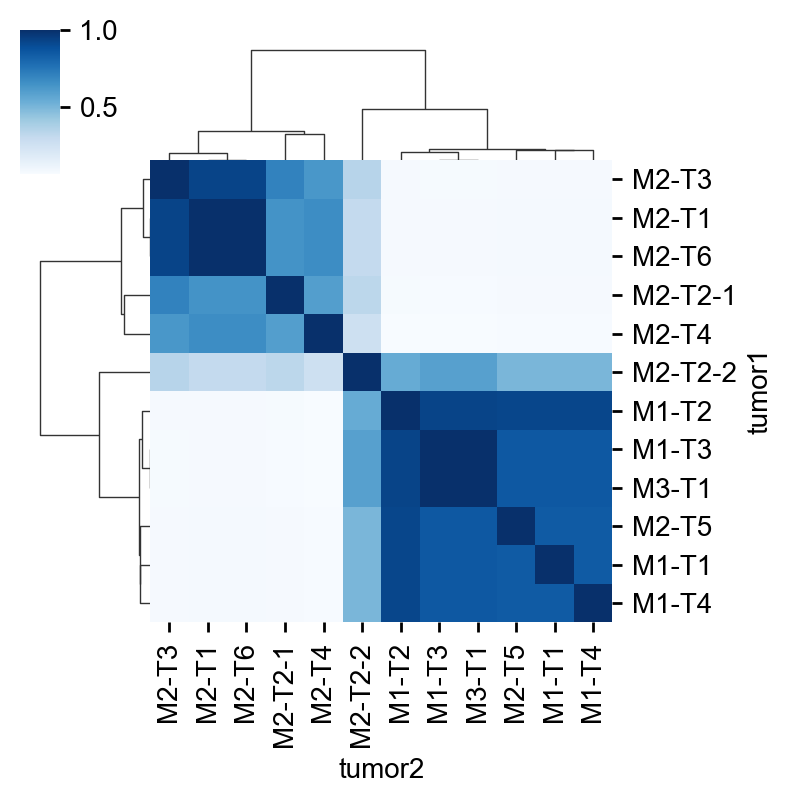

In [84]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

clone_similarity = []
for _, row1 in tumor_clones.iterrows():
    for _, row2 in tumor_clones.iterrows():
        set1 = set(row1['intBCs'])
        set2 = set(row2['intBCs'])
        sim = jaccard_similarity(set1, set2)
        clone_similarity.append({
            'tumor1': row1['tumor'],
            'tumor2': row2['tumor'],
            'jaccard': sim
        })
clone_similarity = pd.DataFrame(clone_similarity)
similarity_mat = clone_similarity.pivot(index="tumor1", columns="tumor2", values="jaccard").fillna(0)
sns.clustermap(similarity_mat, cmap="Blues", annot=False, cbar=True, figsize=(4, 4))

Calculate jaccard similarity between invitro cells and tumor clones

In [85]:
adata.obs["intBCs"] = adata.obsm["intBC_detected"].apply(lambda row: row.index[row == 1].tolist(), axis=1)
tumor_clone_similarity = []
for _, row in tumor_clones.iterrows():
    clone_intBCs = row["intBCs"]
    tumor_clone = row["tumor"]
    tumor_clone_similarity.append(
        adata.obs["intBCs"].apply(lambda x: jaccard_similarity(set(x), set(clone_intBCs)))
    )
tumor_clone_similarity = pd.DataFrame(data = np.array(tumor_clone_similarity).T,
    columns = tumor_clones["tumor"].values,
    index = adata.obs.index
)
adata.obsm["tumor_clone_similarity"] = tumor_clone_similarity

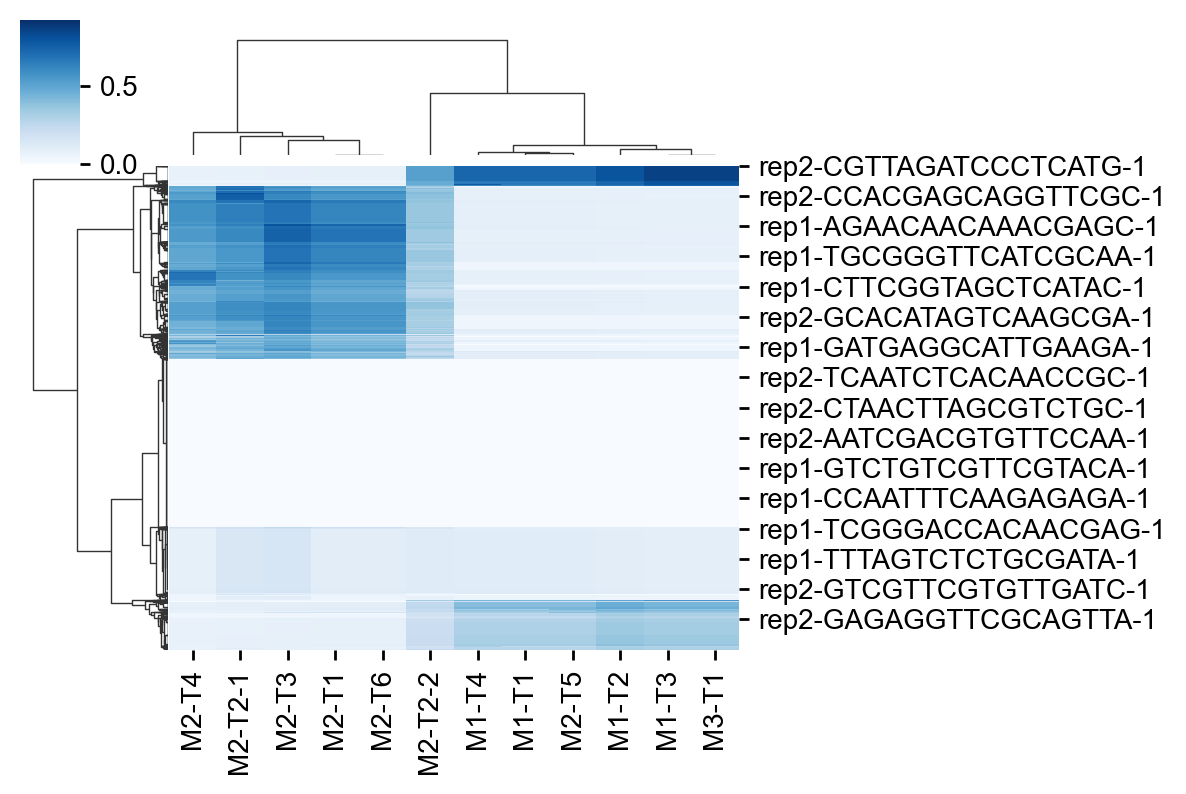

In [96]:
sns.clustermap(adata.obsm["tumor_clone_similarity"], cmap="Blues", annot=False, cbar=True, figsize=(6, 4))

## Write data

In [95]:
adata.obs.drop(columns = ["intBCs"], inplace = True)
adata.write_h5ad(data_path / "4T1_invitro.h5ad")
filtered_alleles.to_csv(data_path / "4T1_invitro_alleles.csv")
tumor_clones.to_csv(results_path / "tumor_clone_intBCs.csv")
tumor_clone_similarity.to_csv(results_path / "tumor_clone_similarity.csv")